Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1352, 6)
[[-3.34  1.25 -3.56]
 [ 2.08 -2.96  8.53]
 [ 2.76 -3.15 -2.86]
 [ 2.77 -2.82  2.46]]
5.039017761429305
9.26546814791352
5.071459356043386
4.655845787824163
(1352, 3)


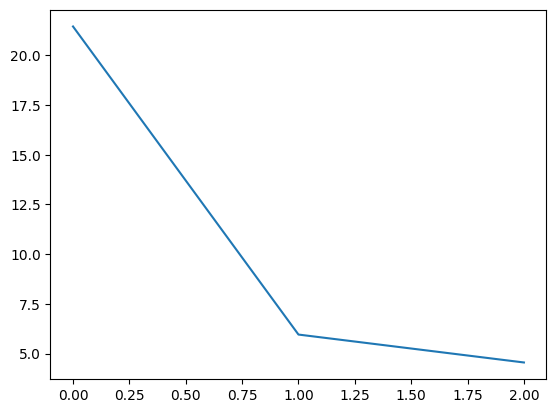

(1352, 1352) (3,) (3, 3)
Decision Tree  	|	 1.0|		 0.9768902543096092±0.010489882381800548|	0.9704797047970479


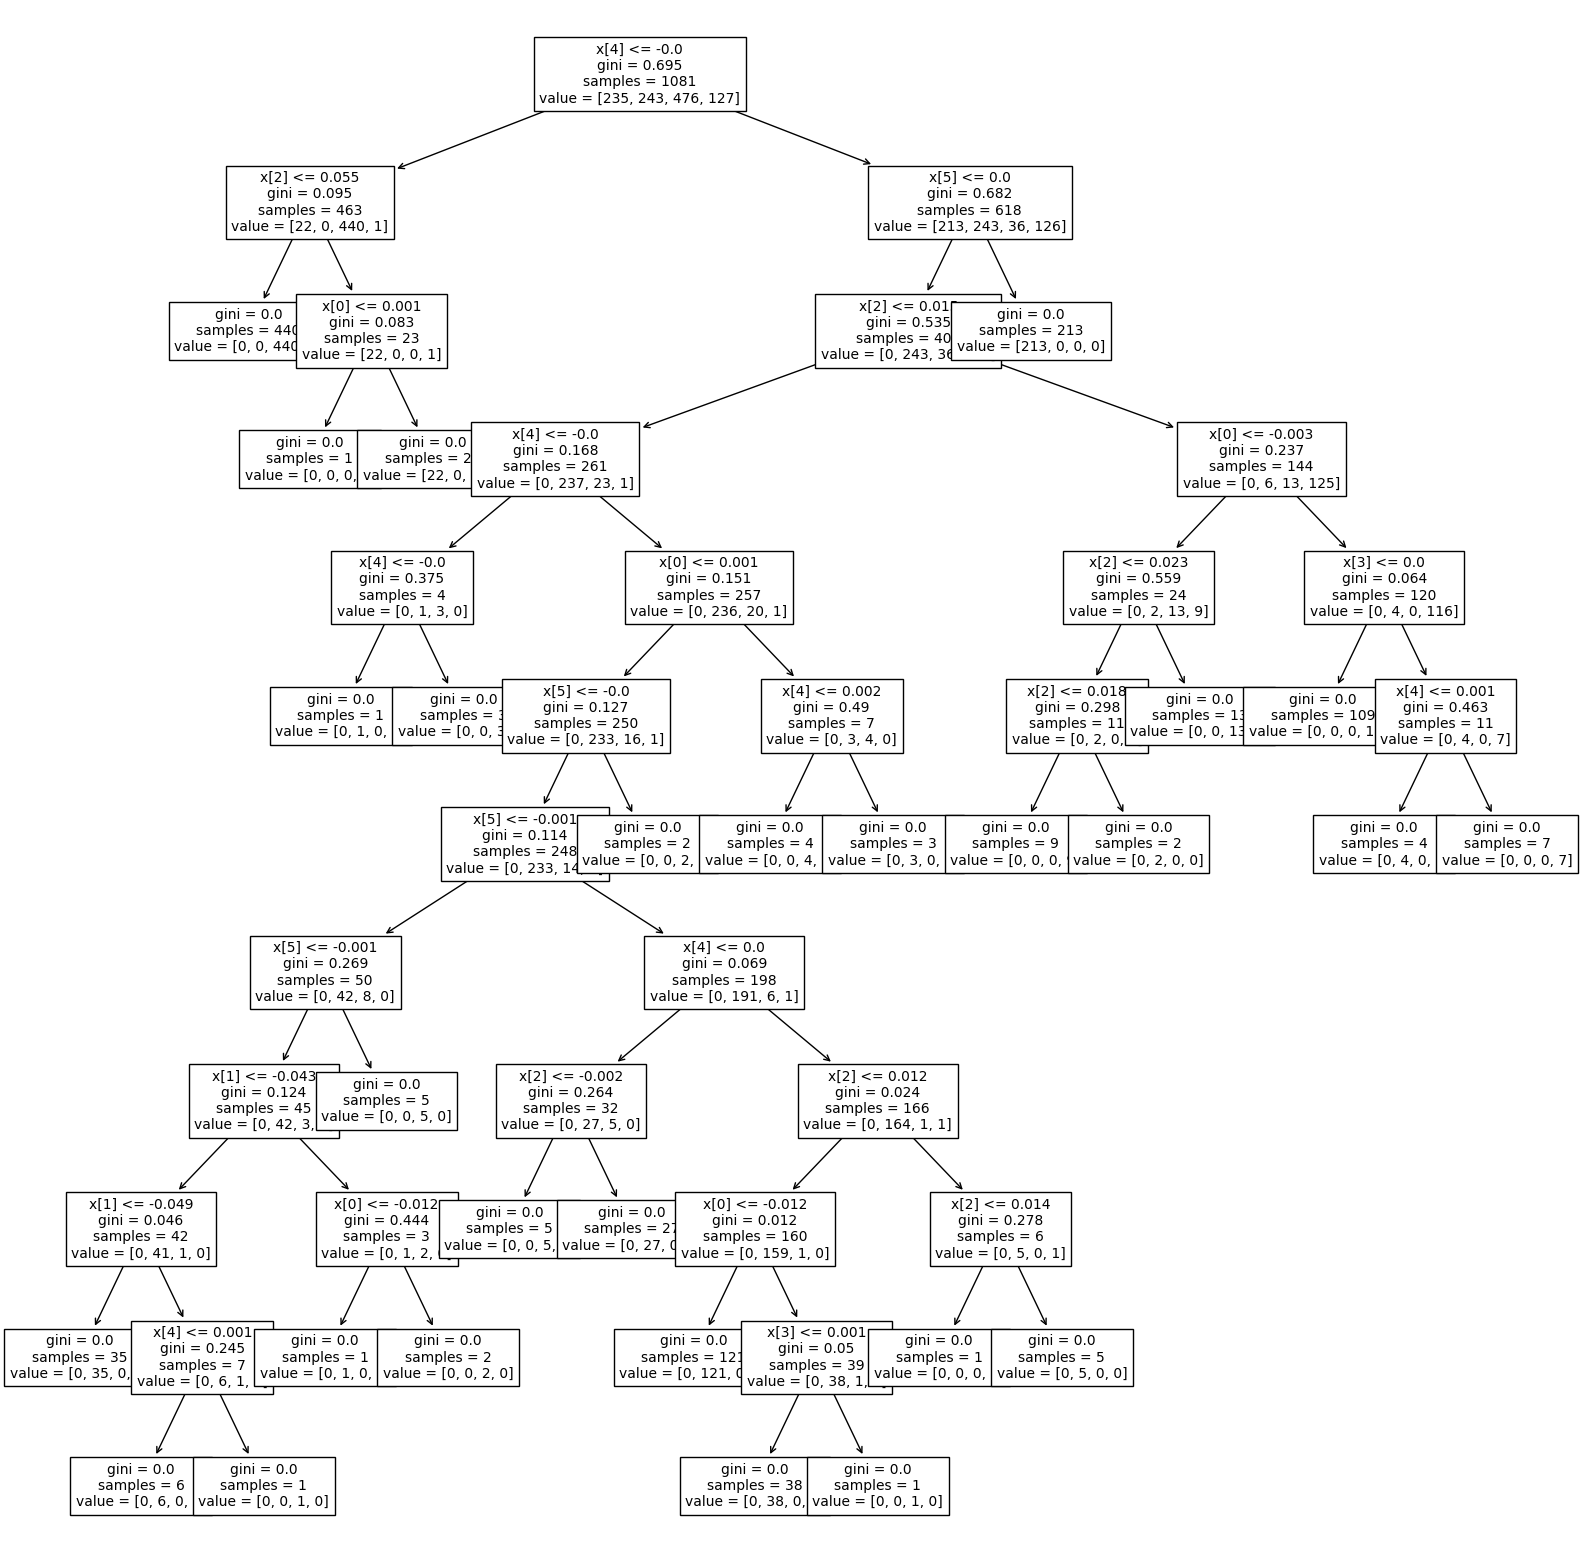

Random Forest	|	 1.0|		 0.9815156169994879±0.010497353434504569|	0.974169741697417
LightGBM	|	 1.0|		 0.9815070831199865±0.007716361498785853|	0.9704797047970479
1-NN Classifier	|	 1.0|		 0.9815070831199865±0.009686887404735119|	0.9704797047970479
3-NN Classifier	|	 0.9907493061979649|		 0.9777991124765318±0.007404863028807618|	0.959409594095941
10-NN Classifier	|	 0.9703977798334875|		 0.9648404164533197±0.00695649906532602|	0.9372693726937269
GaussianNB Class.	|	 0.8751156336725254|		 0.8769755931046254±0.01714498975787912|	0.8523985239852399


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from google.colab import drive

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import normalize

def print_tree(clf, X_test):
  node_indicator = clf.decision_path(X_test)
  leaf_id = clf.apply(X_test)
  feature = clf.tree_.feature
  threshold = clf.tree_.threshold

  sample_id = 0
  # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
  node_index = node_indicator.indices[
      node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
  ]

  print("Rules used to predict sample {id}:\n".format(id=sample_id))
  for node_id in node_index:
      # continue to the next node if it is a leaf node
      if leaf_id[sample_id] == node_id:
          continue

      # check if value of the split feature for sample 0 is below threshold
      if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print(
          "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X_test[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id],
          )
      )

# File input
def read_in_data():
    #path = './data/training_data/all_data.txt'
    path = '/content/drive/My Drive/Colab Notebooks/cosmic_sleuth/data/all_data.txt'
    drive.mount('/content/drive')
    with open(path, 'r') as f:
      temp = np.genfromtxt(f,delimiter=' ')

    X = temp[:, :-3]
    y = temp[:, -3:]

    print(X.shape)

    return X, y

# Find all unique x,y,x coordinates, assign them a label
def enumerate_unique_labels(y):
    y_options = np.unique(y, axis=0)
    # Convert x,y,z coordinate into an enumerated label
    print(y_options)
    print(np.linalg.norm(y_options[0]))
    print(np.linalg.norm(y_options[1]))
    print(np.linalg.norm(y_options[2]))
    print(np.linalg.norm(y_options[3]))
    y_labels = np.array([np.where(y_options == yi)[0][0] for yi in y])
    return y_labels

def eval_classifier(clf, X_train, X_test, y_train, y_test):
    clf = clf.fit(X_train, y_train)

    print('|\t', clf.score(X_train, y_train), end="|\t")

    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print('\t', str(scores.mean()) + '±' + str(scores.std()), end="|\t")
    print(clf.score(X_test, y_test))

    return clf

def mlp():
    # Create the model
    model = Sequential()
    model.add(Dense(10, input_dim = 6, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def eval_mlp(model, X_train, X_test, y_train, y_test):
    # Convert target classes to categorical ones
    Y_train = to_categorical(y_train)
    Y_test = to_categorical(y_test)

    model.fit(X_train, Y_train, epochs=100, batch_size=45, verbose=1)
    # Test the model after training
    test_results = model.evaluate(X_test, Y_test, verbose=1)
    print(f'Mulilayer Perceptron results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
    
def eval_Linregression(X_train, X_test, y_train, y_test):
    possibleys = [0, 1, 2, 3]
    clf = LinearRegression().fit(X_train, y_train)
    yhat = clf.predict(X_test)
    yclass = yhat
    for i in range(yhat.shape[0]): 
      yclass[i] = np.argmin(np.linalg.norm(possibleys - yhat[i]))
    score = sum([y1 == y2 for (y1, y2) in zip(yclass, y_test)])
    score = 1.0 * score / y_test.shape[0]

    print('\tLinearRegression Score\t ', score)
    return clf

def main():
    X, y = read_in_data()
    y_labels = enumerate_unique_labels(y)
    # print(np.unique(y_labels))

    # X_norm = normalize(X)
    # X_norm = normalize(X-X.mean(axis=0))


    # X_momentum = normalize((X - X.mean(axis=0))[:, 2:5])
    X_momentum = ((X - X.mean(axis=0))[:, 2:5])
    print(X_momentum.shape)

    U, S, Vh = np.linalg.svd(X_momentum)
    plt.plot(range(len(S)), S)
    plt.show()

    print(U.shape, S.shape, Vh.shape)

    # pca = PCA(n_components=6)
    # X_transform = pca.fit_transform(X)

    # sfs = SequentialFeatureSelector(DecisionTreeClassifier(), n_features_to_select=3)
    # sfs.fit(X, y)

    # sfs.get_support()

    # X_sfs = sfs.transform(X).shape

    # X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(X_norm, y_labels, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(X_momentum, y_labels, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(U[:, :6], y_labels, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(U[:, :10], y_labels, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(X_transform, y_labels, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(X_sfs, y_labels, test_size=0.2)


    # Evaluate many different classifiers
    print('Decision Tree  ', end='\t')
    clf = eval_classifier(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
    plt.figure(figsize=(20,20))  # set plot size (denoted in inches)
    tree.plot_tree(clf, fontsize=10)
    plt.show()

    print('Random Forest', end='\t')
    eval_classifier(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train, y_test)

    print('LightGBM', end='\t')
    eval_classifier(LGBMClassifier(objective='multiclass'), X_train, X_test, y_train, y_test)

    print('1-NN Classifier', end='\t')
    eval_classifier(KNeighborsClassifier(n_neighbors=1), X_train, X_test, y_train, y_test)
    print('3-NN Classifier', end='\t')
    eval_classifier(KNeighborsClassifier(n_neighbors=3), X_train, X_test, y_train, y_test)
    print('10-NN Classifier', end='\t') 
    eval_classifier(KNeighborsClassifier(n_neighbors=10), X_train, X_test, y_train, y_test)
    print('GaussianNB Class.', end='\t')
    eval_classifier(GaussianNB(), X_train, X_test, y_train, y_test)
    # print('LinearRegression', end='\t')
    # eval_classifier(LinearRegression(), X_train, X_test, y_train, y_test)
    # print('LinearRegression', end='\t')
    # eval_Linregression(X_train, X_test, y_train, y_test)
    # print('LogisticRegression', end='\t')
    # eval_classifier(LogisticRegression(), X_train, X_test, y_train, y_test)
    # print('Perceptron Class.', end='\t')
    # eval_classifier(Perceptron(), X_train, X_test, y_train, y_test)

    # eval_mlp(mlp(), X_train, X_test, y_train, y_test)

main()


# **Raw data - no preprocessing, no feature selection**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree| 		 1.0	|	 0.9676181942310975±0.01056852499751914	| 0.988929889298893
Random Forest|		 1.0	|	 0.9805811571940604±0.006772903668057862 | 0.996309963099631
LightGBM|		 1.0	|	 0.9796552312681346±0.008564722808598338 |	0.996309963099631
1-NN Classifier|	 1.0	|	 0.7576164874551972±0.013221021756934041	| 0.7638376383763837
3-NN Classifier |	 0.8667900092506938	|	 0.6401220344768732±0.019058889075391473	| 0.6752767527675276
10-NN Classifier:	|	 0.6086956521739131	|	 0.481920976275815±0.03776620285096625 |	0.47601476014760147
GaussianNB Class. |	 0.43940795559666973	|	 0.4320063150708312±0.012565039994652463 |	0.4095940959409594
MLP | | | 0.24354243278503418

# **De-meaned data**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9787079706434547±0.012633579252462784|	0.981549815498155
Random Forest	|	 1.0|		 0.982415941286909±0.007417021446156035|	0.981549815498155
LightGBM	|	 1.0|		 0.9879629629629629±0.006279935169560418|	0.992619926199262
1-NN Classifier	|	 1.0|		 0.7483273596176823±0.029428569036024328|	0.8265682656826568
3-NN Classifier	|	 0.8584643848288621|		 0.651216077828981±0.02359897524383146|	0.7121771217712177
10-NN Classifier	|	 0.6086956521739131|		 0.4764251578767708±0.02642824128945828|	0.44280442804428044
GaussianNB Class.	|	 0.4320074005550416|		 0.43200631507083126±0.001886595455548059|	0.43911439114391143

# **Normalized data**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 0.43293246993524515|		 0.43293224099675715±0.0020741277682791892|	0.4354243542435424
Random Forest	|	 0.43293246993524515|		 0.43293224099675715±0.0020741277682791892|	0.4354243542435424
LightGBM	|	 1.0|		 0.9519073220686124±0.011128718768872357|	0.940959409594096
1-NN Classifier	|	 1.0|		 0.9158175456562553±0.01767023366837762|	0.9188191881918819
3-NN Classifier	|	 0.9602220166512488|		 0.9167306707629288±0.01609335029602989|	0.9188191881918819
10-NN Classifier	|	 0.9204440333024977|		 0.8806750298685782±0.011003642604307341|	0.8892988929889298
GaussianNB Class.	|	 0.5661424606845513|		 0.5013910223587643±0.048014251035684304|	0.5830258302583026

# **Normalized De-meaned data**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 0.4338575393154487|		 0.433858166922683±0.001824853951634347|	0.4317343173431734
Random Forest	|	 0.4338575393154487|		 0.433858166922683±0.001824853951634347|	0.4317343173431734
LightGBM	|	 0.9990749306197965|		 0.974078341013825±0.01296997384857319|	0.959409594095941
1-NN Classifier	|	 1.0|		 0.9472606246799795±0.007579158863958893|	0.955719557195572
3-NN Classifier	|	 0.967622571692877|		 0.926915855948114±0.006181698682998776|	0.9372693726937269
10-NN Classifier	|	 0.9148936170212766|		 0.8788146441372247±0.013867176068472617|	0.8929889298892989
GaussianNB Class.	|	 0.4338575393154487|		 0.433858166922683±0.001824853951634347|	0.4317343173431734

# **SVD of data; First 6 left singular vectors U[:, :6]**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9463432326335554±0.014823909993840827|	0.974169741697417
Random Forest	|	 1.0|		 0.9676480628093531±0.018201449639755774|	0.977859778597786
LightGBM	|	 1.0|		 0.9694828469022019±0.013577101908362876|	0.977859778597786
1-NN Classifier	|	 1.0|		 0.963009899300222±0.013996176392227649|	0.985239852398524
3-NN Classifier	|	 0.9787234042553191|		 0.9482036183649086±0.007907646733981342|	0.955719557195572
10-NN Classifier	|	 0.9500462534690102|		 0.9352577231609489±0.007617074286208589|	0.9520295202952029
GaussianNB Class.	|	 0.8538390379278445|		 0.844636456733231±0.02797049600672642|	0.8782287822878229

# **SVD of de-meaned data; First 6 left singular vectors U[:, :6]**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9639272913466461±0.010698719873910401|	0.9261992619926199
Random Forest	|	 1.0|		 0.9759429936849292±0.005416671200151715|	0.955719557195572
LightGBM	|	 1.0|		 0.9759472606246801±0.005402855658736497|	0.9520295202952029
1-NN Classifier	|	 1.0|		 0.9731694828469022±0.008986083940818545|	0.948339483394834
3-NN Classifier	|	 0.9851988899167438|		 0.9629885646014678±0.007777560260998169|	0.9446494464944649
10-NN Classifier	|	 0.9639222941720629|		 0.948195084485407±0.019291987436059248|	0.9372693726937269
GaussianNB Class.	|	 0.9463459759481961|		 0.9454301075268818±0.010662120240782447|	0.9372693726937269

# **SVD of normalized data; First 6 left singular vectors U[:, :6]**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.922273425499232±0.021046575539451898|	0.9114391143911439
Random Forest	|	 1.0|		 0.9537506400409625±0.013078301893748168|	0.948339483394834
LightGBM	|	 1.0|		 0.9592848608977642±0.009477848135015744|	0.9446494464944649
1-NN Classifier	|	 1.0|		 0.9629842976617169±0.008317545119960095|	0.9704797047970479
3-NN Classifier	|	 0.9805735430157262|		 0.9463218979348011±0.016499975192643745|	0.959409594095941
10-NN Classifier	|	 0.9574468085106383|		 0.9509515275644308±0.013005055582859559|	0.9520295202952029
GaussianNB Class.	|	 0.47363552266419984|		 0.47913893155828646±0.047183250604210615|	0.5202952029520295

# **SVD of normalized de-meaned data; First 6 left singular vectors U[:, :6]**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9491082095920806±0.010602212807103238|	0.9520295202952029
Random Forest	|	 1.0|		 0.9583674688513397±0.010158808443008635|	0.9704797047970479
LightGBM	|	 1.0|		 0.9565070831199863±0.012316664794382301|	0.966789667896679
1-NN Classifier	|	 1.0|		 0.8982548216419184±0.016733325283157297|	0.9446494464944649
3-NN Classifier	|	 0.9500462534690102|		 0.8843616658132788±0.011754334030093865|	0.915129151291513
10-NN Classifier	|	 0.8908418131359852|		 0.8381080389144906±0.01855702056082919|	0.8487084870848709
GaussianNB Class.	|	 0.4301572617946346|		 0.4070063150708312±0.047074567588560254|	0.44280442804428044

# **SVD of de-meaned normalized data; First 6 left singular vectors U[:, :6]**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9481822836661546±0.013582584114765761|	0.940959409594096
Random Forest	|	 1.0|		 0.954668032087387±0.005425853069827975|	0.966789667896679
LightGBM	|	 1.0|		 0.9509813961426865±0.015060934980820279|	0.966789667896679
1-NN Classifier	|	 1.0|		 0.9565326847584913±0.00851521897338475|	0.974169741697417
3-NN Classifier	|	 0.9740980573543015|		 0.9481993514251579±0.0163962066693385|	0.955719557195572
10-NN Classifier	|	 0.9611470860314524|		 0.9518945212493598±0.013295755506840787|	0.948339483394834
GaussianNB Class.	|	 0.3274745605920444|		 0.3348395630653695±0.02257543263627545|	0.3173431734317343

# **Principal component analysis (n_components=1)**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 0.6086956521739131|		 0.43661887694145757±0.01758181327517051|	0.45387453874538747
Random Forest	|	 0.6086956521739131|		 0.44679552824714114±0.014674721078064204|	0.43911439114391143
LightGBM	|	 0.574468085106383|		 0.4486388462194914±0.018224082192340677|	0.44649446494464945
1-NN Classifier	|	 0.6558741905642923|		 0.4838154975251749±0.04056986838248187|	0.5166051660516605
3-NN Classifier	|	 0.6308973172987974|		 0.46714029697900666±0.032295182469253794|	0.4907749077490775
10-NN Classifier	|	 0.574468085106383|		 0.45051629970984813±0.024020174819019448|	0.47601476014760147
GaussianNB Class.	|	 0.42738205365402404|		 0.42645502645502653±0.001058201058201047|	0.4575645756457565

# **Principal component analysis (n_components=6)**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9601937190646869±0.019124542964876038|	0.948339483394834
Random Forest	|	 1.0|		 0.9731566820276498±0.01386883027463419|	0.9704797047970479
LightGBM	|	 1.0|		 0.9796381635091314±0.009542947554455582|	0.9630996309963099
1-NN Classifier	|	 1.0|		 0.7372333162655743±0.0346087498198158|	0.7859778597785978
3-NN Classifier	|	 0.8621646623496763|		 0.6410394265232975±0.023623496427044914|	0.7269372693726938
10-NN Classifier	|	 0.5892691951896393|		 0.4615634067246971±0.026639587126339754|	0.5535055350553506
GaussianNB Class.	|	 0.42183163737280294|		 0.4199778119132958±0.0028735677160884768|	0.4797047970479705

# **Momentum features only**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9777905785970301±0.007978538408365711|	0.981549815498155
Random Forest	|	 1.0|		 0.9824202082266599±0.0061496653909398815|	0.985239852398524
LightGBM	|	 1.0|		 0.9805683563748081±0.005412245990268904|	0.985239852398524
1-NN Classifier	|	 1.0|		 0.9759387267451783±0.008991732979880923|	0.977859778597786
3-NN Classifier	|	 0.9861239592969473|		 0.9629928315412186±0.0029754861183780793|	0.966789667896679
10-NN Classifier	|	 0.9685476410730804|		 0.9537421061614608±0.008303528342322754|	0.9520295202952029
GaussianNB Class.	|	 0.9306197964847364|		 0.9306110257723162±0.007813658006159534|	0.922509225092251

# **x Momentum feature only**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 0.9972247918593895|		 0.9287506400409626±0.018244281785345647|	0.940959409594096
Random Forest	|	 0.9972247918593895|		 0.9287506400409626±0.018244281785345647|	0.940959409594096
LightGBM	|	 0.938945420906568|		 0.8972862263184844±0.027916260842042875|	0.9003690036900369
1-NN Classifier	|	 0.9972247918593895|		 0.9278289810547875±0.017272999010798547|	0.940959409594096
3-NN Classifier	|	 0.9611470860314524|		 0.9046936337258918±0.027151742986279467|	0.9077490774907749
10-NN Classifier	|	 0.8945420906567992|		 0.8612220515446323±0.0303563942817208|	0.8745387453874539
GaussianNB Class.	|	 0.81313598519889|		 0.8122119815668203±0.01508398507859834|	0.8228782287822878

# **y Momentum feature only**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 0.9981498612395929|		 0.9417477385219319±0.019431807593419035|	0.9520295202952029
Random Forest	|	 0.9972247918593895|		 0.9408218125960062±0.018486131259955116|	0.9520295202952029
LightGBM	|	 0.9472710453283997|		 0.917673664447858±0.012177949208447924|	0.8819188191881919
1-NN Classifier	|	 0.9981498612395929|		 0.9417477385219319±0.019431807593419035|	0.9520295202952029
3-NN Classifier	|	 0.9592969472710453|		 0.9010411332991979±0.024129107029297908|	0.8966789667896679
10-NN Classifier	|	 0.906567992599445|		 0.8603259941969619±0.016298254332195297|	0.8487084870848709
GaussianNB Class.	|	 0.816836262719704|		 0.8196151220344768±0.010888691847295085|	0.7933579335793358

# **z Momentum feature only**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 0.9555966697502313|		 0.9269371906468681±0.019862417087113785|	0.940959409594096
Random Forest	|	 0.9555966697502313|		 0.9278588496330432±0.01351514756330251|	0.940959409594096
LightGBM	|	 0.9444958371877891|		 0.9158346134152586±0.018752882244718657|	0.933579335793358
1-NN Classifier	|	 0.9398704902867715|		 0.912152244410309±0.018978274531252053|	0.9298892988929889
3-NN Classifier	|	 0.9500462534690102|		 0.9075140809011776±0.019516900327622363|	0.9298892988929889
10-NN Classifier	|	 0.9232192414431082|		 0.9167605393411845±0.016459249833749166|	0.915129151291513
GaussianNB Class.	|	 0.8667900092506938|		 0.8575439494794335±0.017866229585701016|	0.8634686346863468

# **x, y Momentum features only**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 0.9981498612395929|		 0.975968595323434±0.01248443863289159|	0.977859778597786
Random Forest	|	 0.9981498612395929|		 0.975968595323434±0.014097097183233324|	0.977859778597786
LightGBM	|	 0.9981498612395929|		 0.9731908175456562±0.012493928933158503|	0.977859778597786
1-NN Classifier	|	 0.9981498612395929|		 0.9722648916197304±0.015162731156871482|	0.9704797047970479
3-NN Classifier	|	 0.9851988899167438|		 0.9667136030039256±0.012832812610616508|	0.9630996309963099
10-NN Classifier	|	 0.9592969472710453|		 0.9371181088923024±0.01467826406006005|	0.9520295202952029
GaussianNB Class.	|	 0.786308973172988|		 0.7881549752517495±0.025116856535561106|	0.8154981549815498

# **y, z Momentum features only**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9805726233145589±0.008979010040259134|	0.981549815498155
Random Forest	|	 1.0|		 0.9805726233145589±0.004539703060988642|	0.985239852398524
LightGBM	|	 0.9990749306197965|		 0.9759429936849291±0.008987805967457269|	0.985239852398524
1-NN Classifier	|	 1.0|		 0.9759429936849292±0.006818145150742161|	0.977859778597786
3-NN Classifier	|	 0.9842738205365402|		 0.9666922683051714±0.004567626967351166|	0.959409594095941
10-NN Classifier	|	 0.9537465309898242|		 0.9509728622631849±0.006266782230679424|	0.9372693726937269
GaussianNB Class.	|	 0.9435707678075855|		 0.9398660180918246±0.003009647773757034|	0.9298892988929889

# **x, z Momentum features only**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9796594982078854±0.00993658962207158|	0.981549815498155
Random Forest	|	 1.0|		 0.9861239119303635±0.007172237075139177|	0.981549815498155
LightGBM	|	 1.0|		 0.9851937190646869±0.007413824700588947|	0.981549815498155
1-NN Classifier	|	 1.0|		 0.9814942823007339±0.011717226326924313|	0.974169741697417
3-NN Classifier	|	 0.9879740980573543|		 0.9703917050691245±0.0115768405687535|	0.955719557195572
10-NN Classifier	|	 0.96577243293247|		 0.9565156169994878±0.012301983204472037|	0.9298892988929889
GaussianNB Class.	|	 0.906567992599445|		 0.9093445980542756±0.01037967979210308|	0.8745387453874539

# **Rigidity only**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 0.5948196114708603|		 0.43662741082095924±0.029855971664790468|	0.5092250922509225
Random Forest	|	 0.5948196114708603|		 0.4459080047789725±0.020272250963657295|	0.5092250922509225
LightGBM	|	 0.5504162812210915|		 0.4218339307048984±0.030647199039802436|	0.4870848708487085
1-NN Classifier	|	 0.5106382978723404|		 0.3949906127325482±0.03503755427656033|	0.4317343173431734
3-NN Classifier	|	 0.5087881591119334|		 0.39405188598736984±0.03459407817943754|	0.45387453874538747
10-NN Classifier	|	 0.5300647548566142|		 0.41996927803379414±0.025540938310551257|	0.46494464944649444
GaussianNB Class.	|	 0.43940795559666973|		 0.4329493087557603±0.009333909004436786|	0.4095940959409594

# **SVD of de-meaned Momentum features only; U[:, 3]**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9777905785970301±0.010321047240898397|	0.992619926199262
Random Forest	|	 1.0|		 0.9851979860044378±0.009443918571023233|	0.988929889298893
LightGBM	|	 1.0|		 0.9824287421061616±0.011480198029458386|	0.988929889298893
1-NN Classifier	|	 1.0|		 0.9842720600785118±0.012285751839374094|	0.985239852398524
3-NN Classifier	|	 0.9879740980573543|		 0.9787250384024577±0.008582187472937446|	0.966789667896679
10-NN Classifier	|	 0.9759481961147086|		 0.9630098993002217±0.018714003880962275|	0.9630996309963099
GaussianNB Class.	|	 0.9278445883441259|		 0.9204727769243899±0.02223240876283032|	0.9372693726937269

# **SVD of de-meaned Rigitity+Momentum features only; U[:, 3]**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree  	|	 1.0|		 0.9602449223416967±0.016884704910282107|	0.988929889298893
Random Forest	|	 1.0|		 0.9741082095920806±0.012598059947614105|	0.992619926199262
LightGBM	|	 1.0|		 0.9704130397678785±0.013868797455001932|	0.992619926199262
1-NN Classifier	|	 1.0|		 0.9704130397678785±0.010732336605823898|	0.996309963099631
3-NN Classifier	|	 0.9833487511563367|		 0.9620754394947942±0.009427866866708429|	0.977859778597786
10-NN Classifier	|	 0.9620721554116559|		 0.9583674688513397±0.005103028037800984|	0.959409594095941
GaussianNB Class.	|	 0.9472710453283997|		 0.9463603003925585±0.011098329157589343|	0.9520295202952029



